# Perceptron and adaptive linear neurons from scratch in numpy

These code and images are adapted from Chapter 2 and 3 in Raschka. (To retain the images do not execute the image code blocks!)

<br>
<br>

## The formal definition of an artificial neuron

In [1]:
#Image(filename='./figures/02_02.png', width=500) 

## The perceptron learning rule

In [2]:
#Image(filename='./figures/02_03.png', width=600) 

In [3]:
 #Image(filename='./figures/02_04.png', width=600) 

<br>
<br>

# Object-oriented APIs

The goals are 

-  Understand and apply Python code for these class definitions.
-  How perceptrons and adaline work; connect the code with the mathematics
-  How loss and gradient descent work in the context of neural networks.
-  Fit these simple models to familiar data sets and experiment
-  Adapt perceptron to obtain linear and logistic regression with gradient descent

## Perceptron classifier

For a perceptron, the "loss function" is simply the error, though it is typically not referred to as that. The perceptron takes the samples one at a time and adjusts the weights and bias each time. It goes through all the samples and then repeats for however many epochs you specify.

In [4]:
import numpy as np


class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):     ## loop over epochs
            errors = 0
            for xi, target in zip(X, y):    ## loop over each sample, adjusting weights and bias
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi    ## What is vector and what is scalar here?
                self.b_ += update
                errors += int(update != 0.0)  ## if the update is zero, the sample is correctly classified; counts how many are not
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

## Adaptive linear neurons

Adaline replaces the error from the perceptron with mean square error.

## Minimizing cost functions with gradient descent

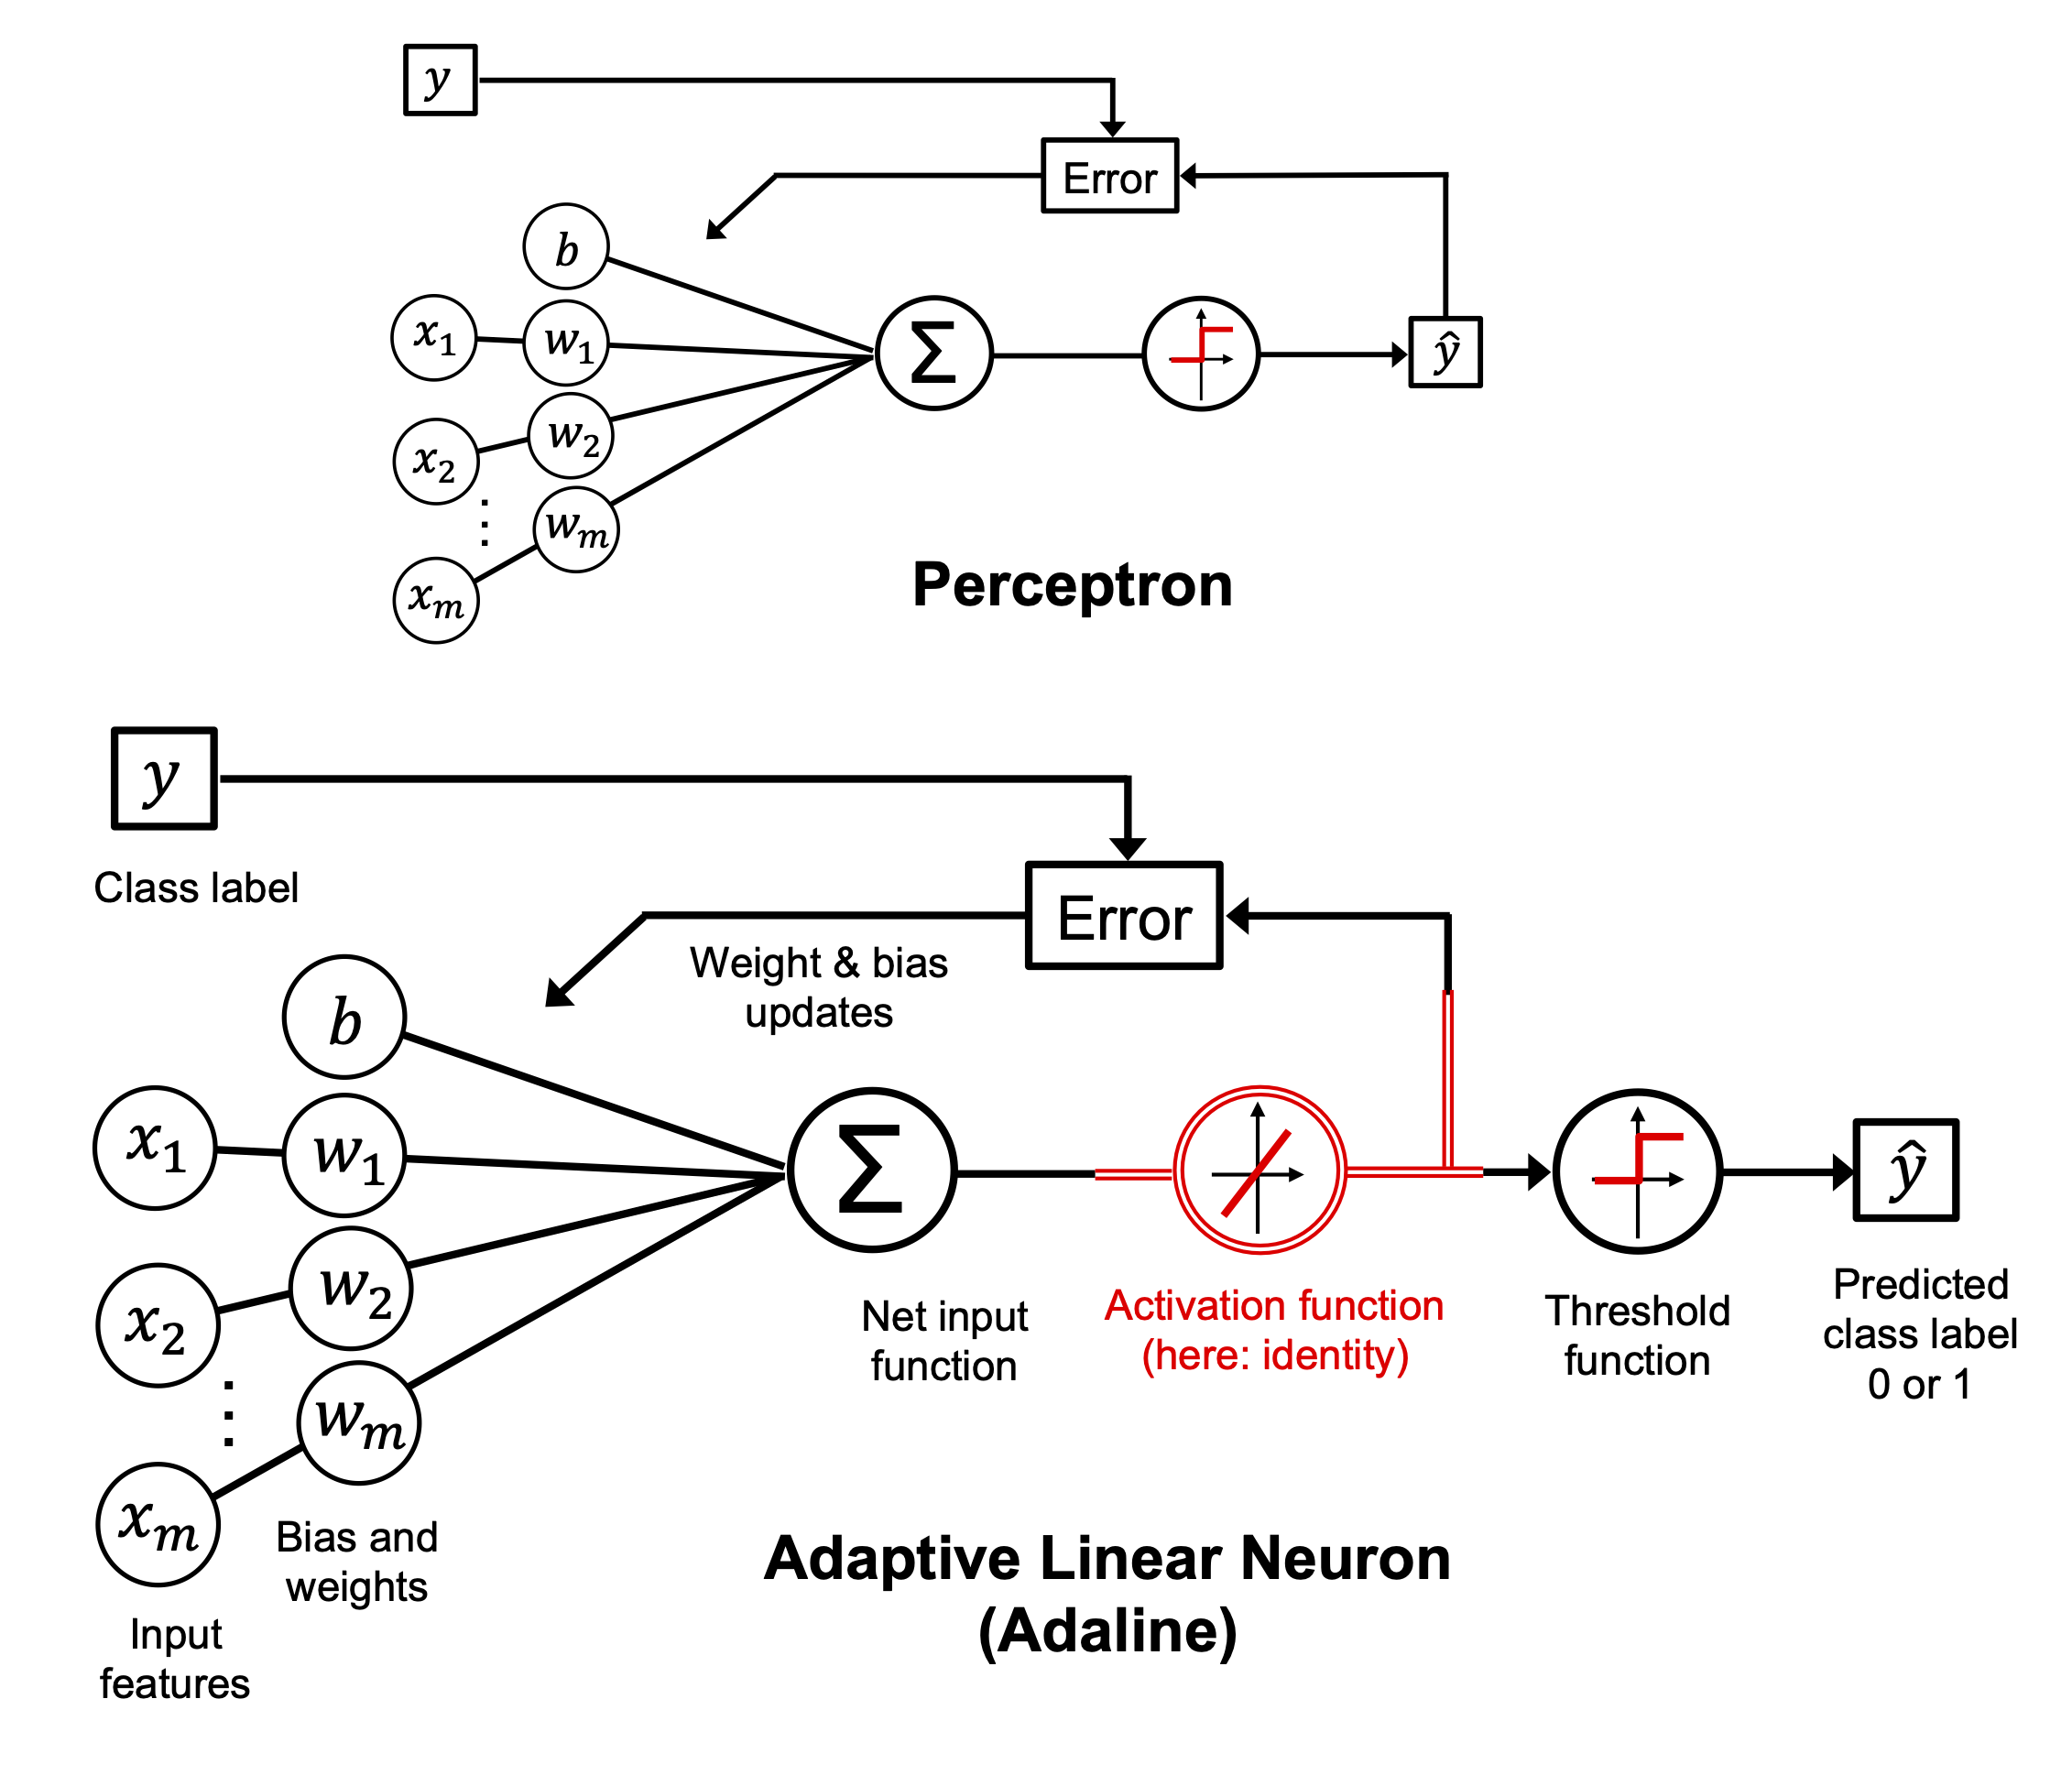

In [15]:
 Image(filename='./figures/02_09.png', width=600) 

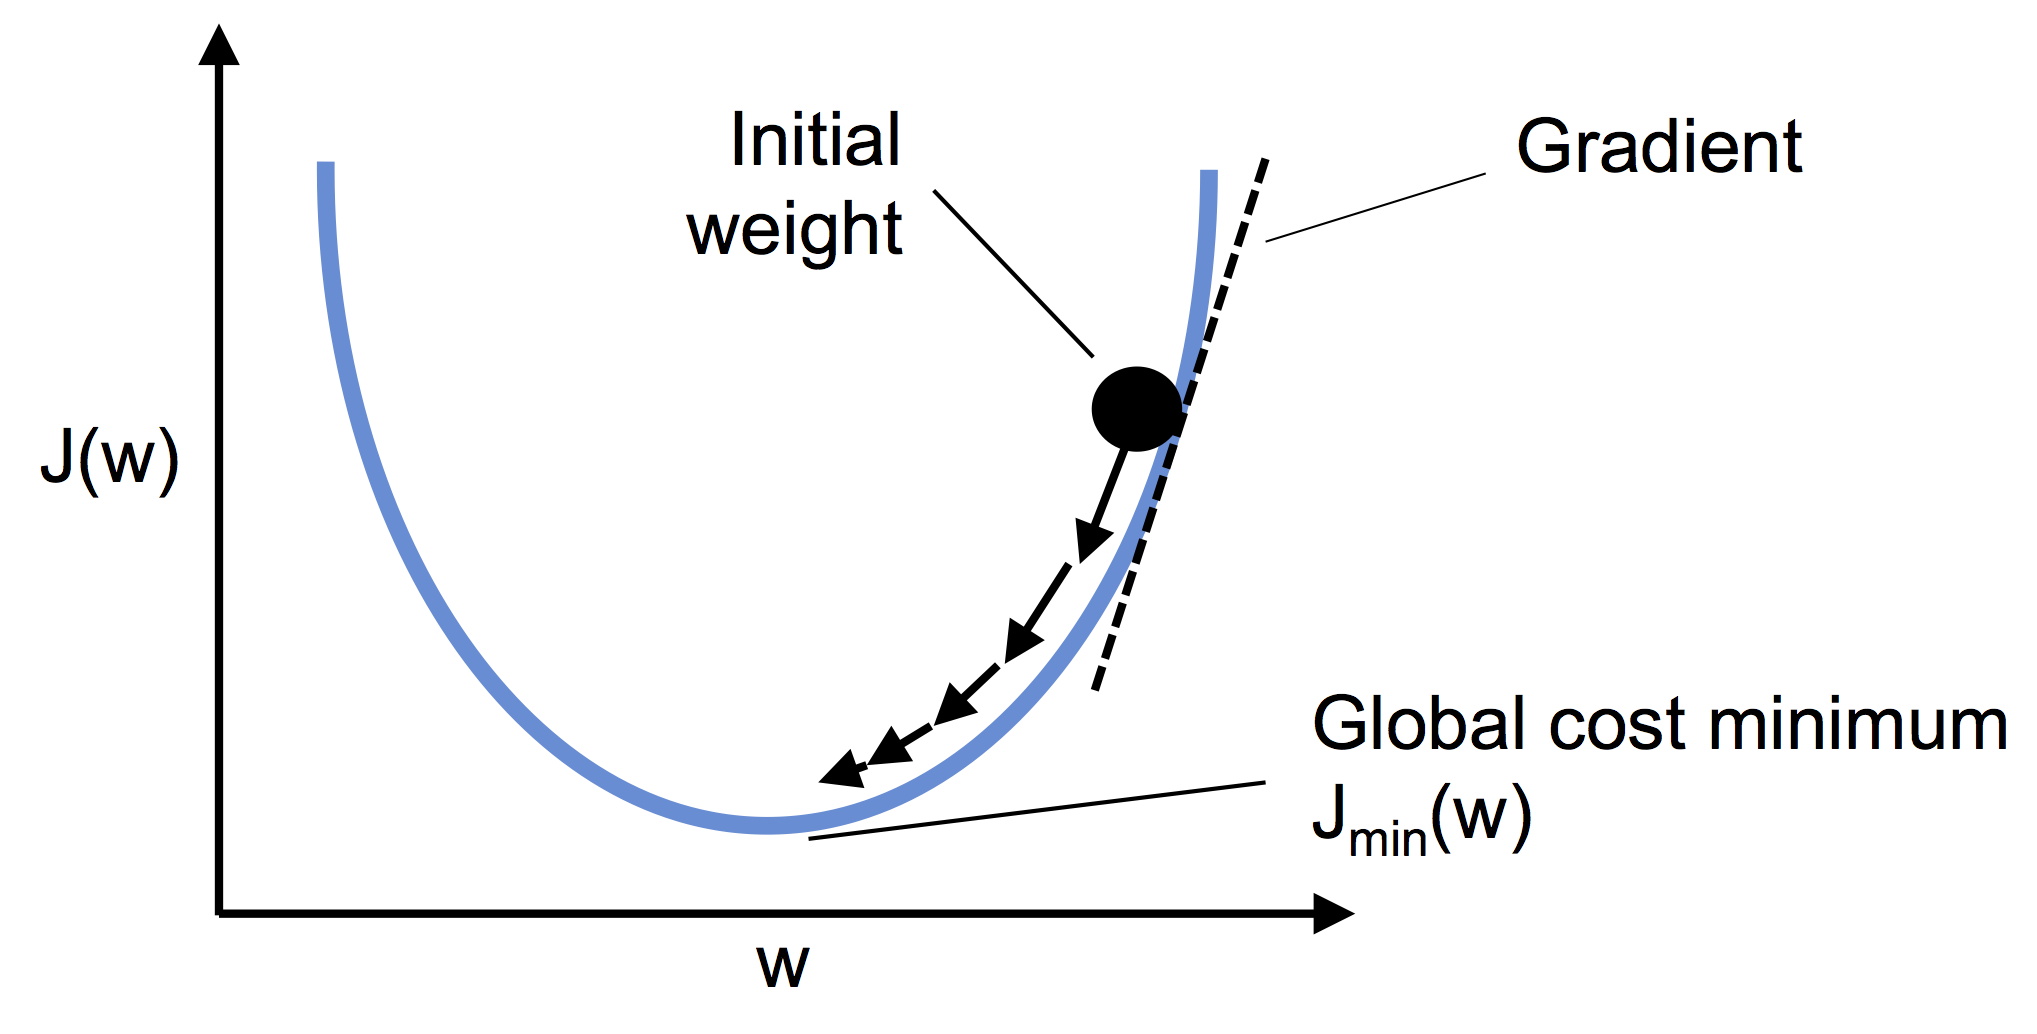

In [16]:
 Image(filename='./figures/02_10.png', width=500) 

<br>
<br>

## Adaptive linear neuron 

The following tweaks to the perceptron yield this implementation below

- remove the activation (below it is kept formally but it is just the identity)
- use mean square error (mse) as loss function, 
- update the weights using gradient of the loss function
- use the entire data set for each weight update.

The thresholding function is still used for predictions, error is the same as before. 

### **Exercise:** Complete the code below.

- Note that there is only one loop in the fit method below, where above there were two nested loops in the fit method. Why is this?

- You will need to define the weight updates below as `eta` times the negative gradient of the mse loss function with respect to the weights. See handout `matrix_least_squares_gradient`. The gradient of the mse loss is also given in matrix form in Geron Eq. 4-6. But note that theta is in place of w. Also, there is no bias term there. What do we do about that? The simplest thing is to absorb it into the weight vector. You will do that in the homework. Here I will just give you the formulas. With the `errors` defined as above, if $J$ is the loss function, the gradient vector is

$$ 
\frac{\partial J}{\partial \beta} = -\frac{2}{n}  {\bf X}^T  \times error
$$

For the bias we have 

$$
\frac{\partial J}{\partial b} = -2 \times mean(errors)
$$

Another bit of weirdness is that `b` is actually a scalar here. When we take in samples in batches for each update, we want to add the same `b` to each sample output. This is called *broadcasting*. Can you spot in the code where we might be trying to add the scalar `b` to a vector? Can we do that? *Broadcasting* allows us to do this. In numpy and keras, this is done automatically-it knows you want to do this. Other computational frameworks would throw a diminesion mismatch error.  

- There is an activation method below. But it is the identity so it does not do anything. We leave it in as a placeholder. Generally we will want an activation. For example, in the case of logistic regression (as we will see later), we could change it to a sigmoid function to implement a logistic regression classifier.

In [ ]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Note that the "activation" method has no effect
            # in the code since it is simply an identity function. 
            output = self.activation(net_input)
            errors = (y - output)

            # The weight and bias updates based on the gradient.
            ## Put the weight updates here !!
            self.w_ += ...
            self.b_ +=  ...    
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):   ## again, this is just the identity function. In other contexts would be replaced with whatever activation is used. 
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

## Logistic Regression

### **Exercise:** Complete the code below.

- You will need to define the weight updates below as `eta` times the negative gradient of the **log loss** function with respect to the weights.  The gradient for the log loss is given in Geron Eq. 4-18. But it is not in matrix form. You will need to use the matrix. The bias updates are similar. Do note that in Eq. 5.83 `errors^T*X` appears below as `X^T*errors`, and $\Phi$ is playing the role of `X`.  Raschka Chapter 2 also has this. 

- There is an activation method below. But it is the identity so it does not do anything. We leave it in as a placeholder. Generally we will want an activation. 

In [ ]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
       Log loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = ...    .
            output = ...   ## output is a vector. The activation function below is vectorized.
            errors = ....     
            self.w_ +=  ......
            self.b_ +=  .......
            loss = .........
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))  ## z is a vector when called above in the fit method
                                                            ## It is the matrix product of data matrix and the weights.

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

<br>
<br>